In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [29]:
torch.cuda.is_available()

True

In [30]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Daten laden

In [31]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,)
                                   )
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                    (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)

Beispieldaten anschauen

In [32]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

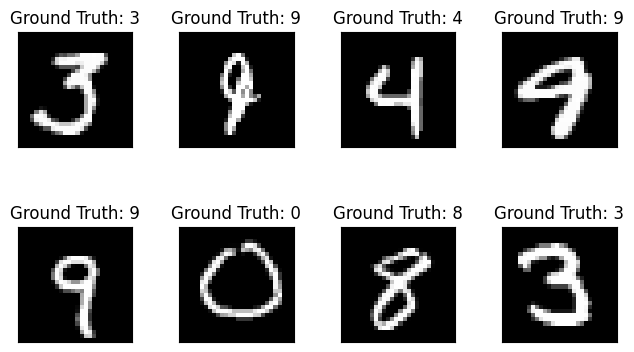

In [33]:
fig = plt.figure()
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

Flatten der Daten

In [34]:
flattened = torch.flatten(example_data, start_dim=1)

D_in, H, D_out = flattened.shape[1], 100, 10

In [35]:
class FNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out, device="cpu"):
    super(FNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
    self.device = device

  def forward(self, x):
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return F.log_softmax(y_pred, dim=1)

In [36]:
def init_net(device="cpu"):
    network = FNet(D_in, H, D_out, device).to(device)
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
    return network, optimizer

def train(network, optimizer, epoch, train_losses=[], train_counter=[]):
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(network.device), target.to(network.device)
        flattened_data = torch.flatten(data, start_dim=1)
        
        optimizer.zero_grad()
        
        output = network(flattened_data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    return train_losses, train_counter, network

In [37]:
def test(network):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(network.device), target.to(network.device)
      flattened_data = torch.flatten(data, start_dim=1)
      output = network(flattened_data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Training des Netzes auf der CPU

In [38]:
network, optimizer = init_net()
train_losses, train_counter = [], []

start = timer()
for epoch in range(1, n_epochs + 1):
    train(network, optimizer, epoch, train_losses, train_counter)
end = timer()

time_elapsed_cpu = end - start

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346312
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.061338
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.787498
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.563534
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.323617
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.157442
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.067432
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.896387
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.772467
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.583144
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.607685
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.453165
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.664993
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.581345
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.789183
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.552753
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.481114
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.365733
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.468975
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.505924
Train Epoch: 1 [12800/60000 (

In [1]:
test(network)
print('\nTime (CPU): {}'.format(time_elapsed_cpu))

NameError: name 'test' is not defined

Text(0, 0.5, 'negative log likelihood loss')

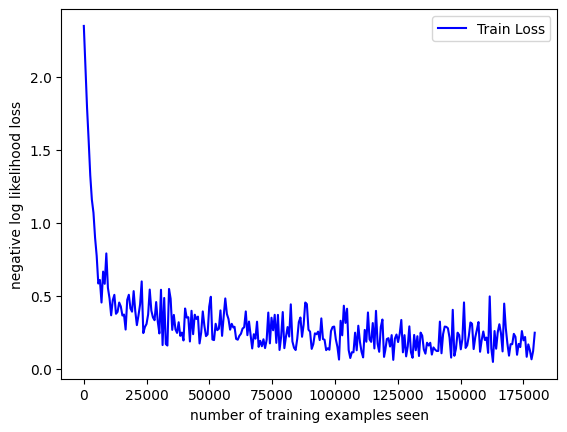

In [39]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Training des Netzes auf der GPU

In [40]:
network, optimizer = init_net("cuda:0")

start = timer()
for epoch in range(1, n_epochs + 1):
    train(network, optimizer, epoch)
end = timer()

time_elapsed_gpu = end - start

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.359850
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.990446
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.751688
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.475166
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.327116
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.022877
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.943348
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.759736
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.664744
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.792947
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.599995
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.469690
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.508056
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.525757
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.501983
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.440136
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.648904
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.482666
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.424899
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.464765
Train Epoch: 1 [12800/60000 (

In [ ]:
test(network)
print('\nTime (CPU): {}\nTime (GPU): {}'.format(time_elapsed_cpu, time_elapsed_gpu))